In [2]:
'''
Chapter 5: Advanced Prompt Engineering
    Input/Output Validation
    
    Chain of Thought Prompting (do a JSON output and show with and without a "step_by_step_reasoning" and try reasoning before and after the answer)
    
    Prompt Chaining Workflows (fine-tuned star classify to filter for good/bad and then if bad, do this, if good, other)
    
    Preventing against Prompt Injection Attacks (prompt against it or Input/Output Validation)
    Building a bot that can execute code on our behalf
    
    ### extra
    
    dynamic k shot using embeddings?
'''

'\nChapter 5: Advanced Prompt Engineering\n    Input/Output Validation\n    \n    Chain of Thought Prompting (do a JSON output and show with and without a "step_by_step_reasoning" and try reasoning before and after the answer)\n    \n    Prompt Chaining Workflows (fine-tuned star classify to filter for good/bad and then if bad, do this, if good, other)\n    \n    Preventing against Prompt Injection Attacks (prompt against it or Input/Output Validation)\n    Building a bot that can execute code on our behalf\n    \n    ### extra\n    \n    dynamic k shot using embeddings?\n'

In [3]:
# TODO add batch processing
# TODO more on k shot learning (using embeddings to retrieve examples in real time)

In [4]:
import os
import openai
import cohere
import json
from transformers import pipeline

import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch

from transformers import ViltForQuestionAnswering, ViltProcessor
from transformers import BlipProcessor, BlipForQuestionAnswering
from transformers import T5Tokenizer, T5ForConditionalGeneration



In [6]:
co = cohere.Client(os.getenv('COHERE_API_KEY'))
openai.api_key = os.getenv("OPENAI_API_KEY")


In [7]:

def test_prompt_openai(prompt, suppress=False, model='text-davinci-003', **kwargs):
    
    if model in ('gpt-3.5-turbo', 'gpt-4'):
        response = openai.ChatCompletion.create(
            model=model,
            messages=[{'role': 'user', 'content': prompt}]
        ).choices[0].message.content.strip()
        if not suppress:
            print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{prompt}\n{response}')


    else:
        response = openai.Completion.create(
              model=model,
              prompt=prompt,
              max_tokens=256,
              **kwargs
            ).choices[0].text
        if not suppress:
            print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{prompt}{response}')
    return response


In [8]:
def test_prompt_cohere(prompt, suppress=False, model='command-xlarge-nightly', **kwargs):
    response = co.generate(
        model=model,
        prompt=prompt,
        max_tokens=256,
        **kwargs,
      ).generations[0].text
    if not suppress:
        print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{prompt}{response}')
    return response

# Using ViT and GPT2 to caption an incoming image

In [170]:

from transformers import pipeline

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


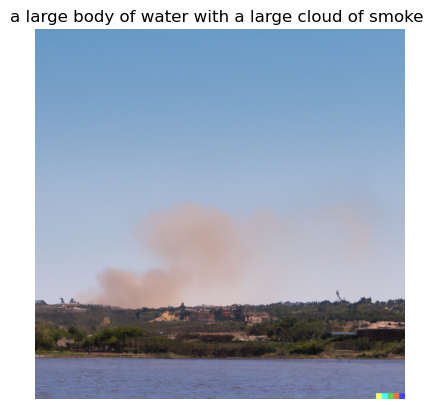

In [208]:
url = '../images/smoke_in_the_distance.png'  # could also use a url here

caption = image_to_text(url)[0]['generated_text']
image = Image.open(requests.get(url, stream=True).raw if 'https' in url else url)

# display image with the generated caption and probability
plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()


In [218]:
caption

'a large body of water with a large cloud of smoke '

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


# Using BART's MNLI to detect issue

In [236]:
candidate_labels = ["something happening outside", "something happening indoors", "potential electrical issue", "potential fire", "no safety issue"]

categories = classifier(caption, candidate_labels, multi_label=True)  # Assuming there can be multiple answers

THRESHOLD = 0.3

for label, score in zip(categories['labels'], categories['scores']):
    print(f'Label "{label}" has score {score*100:.2f}%')

categories_parsed = [(label, score) for label, score in zip(categories['labels'], categories['scores']) if score > THRESHOLD]

categories_parsed


Label "something happening outside" has score 88.35%
Label "potential fire" has score 48.51%
Label "potential electrical issue" has score 2.54%
Label "something happening indoors" has score 0.03%
Label "no safety issue" has score 0.02%


[('something happening outside', 0.883455753326416),
 ('potential fire', 0.4851089119911194)]

# Using OpenAI to detect issue

In [241]:
categories = test_prompt_openai(
    f'Given an image of {caption}. List all categories this image belongs in as a python list. '
    f'The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]',
    temperature=0
)

categories_parsed = json.loads(categories)

categories_parsed

PROMPT:
------
Given an image of a large body of water with a large cloud of smoke . List all categories this image belongs in as a python list. The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]
------
RESPONSE
------
Given an image of a large body of water with a large cloud of smoke . List all categories this image belongs in as a python list. The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]

["outdoor", "fire_issue"]


['outdoor', 'fire_issue']

In [266]:
if 'no_issue' in categories_parsed or 'no safety issue' in categories_parsed:
    print('NO ISSUE DETECTED BUT TRYING AGAIN')
    # second chance to find an issue
    follow_up_questions = test_prompt_cohere(
        f'Your primary concern is understanding more about a potential active situation. '
        f'Given an image of {caption}, you want to understand if something might be wrong or someone might be in danger.'
        f'give a numbered list of 10 specific follow up questions that have to do with safety of the issue.'
    )
else:
    print('ISSUE DETECTED! Coming up with follow up questions')
    # understand more
    follow_up_questions = test_prompt_cohere(
    f'Your primary concern is safety and you want to understand more about an active situation. '
    f'Given an image of "{caption}" '
    f'give a numbered list of the 10 specific follow up questions about the image and the surroundings.'
)


ISSUE DETECTED! Coming up with follow up questions
PROMPT:
------
Your primary concern is safety and you want to understand more about an active situation. Given an image of "a large body of water with a large cloud of smoke " give a numbered list of the 10 specific follow up questions about the image and the surroundings.
------
RESPONSE
------
Your primary concern is safety and you want to understand more about an active situation. Given an image of "a large body of water with a large cloud of smoke " give a numbered list of the 10 specific follow up questions about the image and the surroundings.

1. Where is the large body of water located?
2. What is the name of the large body of water?
3. What is the source of the large cloud of smoke?
4. How large is the cloud of smoke?
5. How long has the cloud of smoke been visible?
6. What is the direction of the wind?
7. What is the speed of the wind?
8. What is the temperature?
9. What is the humidity?
10. What is the barometric pressure?


In [267]:
# Split the string into lines
lines = follow_up_questions.strip().split('\n')

# Extract the numbered list as a Python list
numbered_list = []
for line in lines:
    if line and line[0].isdigit() and len(line) > 3:
        numbered_list.append(line.split('. ')[1])

# Print the resulting list
print(numbered_list)


['Where is the large body of water located?', 'What is the name of the large body of water?', 'What is the source of the large cloud of smoke?', 'How large is the cloud of smoke?', 'How long has the cloud of smoke been visible?', 'What is the direction of the wind?', 'What is the speed of the wind?', 'What is the temperature?', 'What is the humidity?', 'What is the barometric pressure?']


# Using Vilt to answer follow up questions

In [268]:
vilt_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
vilt_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")


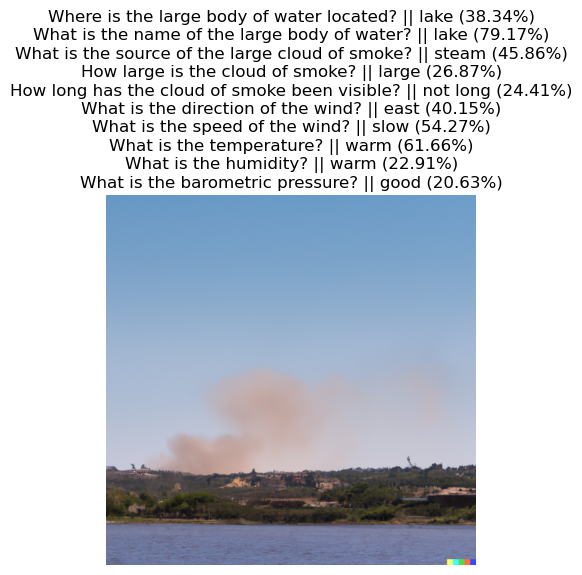

In [269]:
title = ''

for follow_up_question in numbered_list:

    # prepare inputs
    encoding = vilt_processor(image, follow_up_question, return_tensors="pt")
    
    # forward pass
    outputs = vilt_model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()

    # apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)
    predicted_probability = probabilities[0, idx].item()

    predicted_answer = vilt_model.config.id2label[idx]
    title += f"{follow_up_question} || {predicted_answer} ({predicted_probability:.2%})\n"

# display image with the generated caption and probability
plt.imshow(image)
plt.title(title.strip())
plt.axis('off')
plt.show()

In [271]:
print(title)

Where is the large body of water located? || lake (38.34%)
What is the name of the large body of water? || lake (79.17%)
What is the source of the large cloud of smoke? || steam (45.86%)
How large is the cloud of smoke? || large (26.87%)
How long has the cloud of smoke been visible? || not long (24.41%)
What is the direction of the wind? || east (40.15%)
What is the speed of the wind? || slow (54.27%)
What is the temperature? || warm (61.66%)
What is the humidity? || warm (22.91%)
What is the barometric pressure? || good (20.63%)

